In [ ]:
import numpy as np
from ase.io import read
from data import AtomicData, block_to_feature, OrbitalMapper, _keys
from utils.make_kpoints import kmesh_sampling

U = 3.5
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

t = -1.
t_ = 0.3
delta = 0.9
tp = - t_ * (1+delta)
tm = - t_ * (1-delta)

block = {
    "0_0_0_0_0": np.zeros((1,1)),
    "1_1_0_0_0": np.zeros((1,1)),
    
    # 1nn for 0
    "0_1_0_0_0": np.array([[t]]),
    "0_1_-1_0_0": np.array([[t]]),
    "0_1_0_-1_0": np.array([[t]]),
    "0_1_-1_-1_0": np.array([[t]]),
    
    # 1nn for 1
    "1_0_0_0_0": np.array([[t]]),
    "1_0_0_1_0": np.array([[t]]),
    "1_0_1_1_0": np.array([[t]]),
    "1_0_1_0_0": np.array([[t]]),

    # 2nn for 0
    "0_0_-1_0_0": np.array([[tp]]),
    "0_0_1_0_0": np.array([[tp]]),
    "0_0_0_1_0": np.array([[tm]]),
    "0_0_0_-1_0": np.array([[tm]]),

    # 2nn for 1
    "1_1_-1_0_0": np.array([[tm]]),
    "1_1_1_0_0": np.array([[tm]]),
    "1_1_0_1_0": np.array([[tp]]),
    "1_1_0_-1_0": np.array([[tp]]),
}

for k in block:
    block[k] = np.kron(block[k], np.eye(2))

atomicdata = AtomicData.from_ase(
    read("./am.vasp"),
    r_max=2.7
    )

atoms = atomicdata.to_ase()
idp = OrbitalMapper(basis={"C":"1s", "Si":"1s"}, spin_deg=False)

atomicdata[_keys.KPOINT_KEY] = kmesh_sampling([20,20,1], True)
block_to_feature(atomicdata, idp, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)

from hf.hf import HartreeFock

HF = HartreeFock(
    basis=idp.basis,
    nocc=2,
    idx_intorb={"C":[0], "Si":[0]},
    intparams={"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}], "Si":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=2,
    mixer_options={"method": "Linear", "a": 0.7},
    overlap=False,
    dtype=np.float64
)
data = HF.run(max_iter=100,data=atomicdata, tol=1e-9, ntol=1e-7)

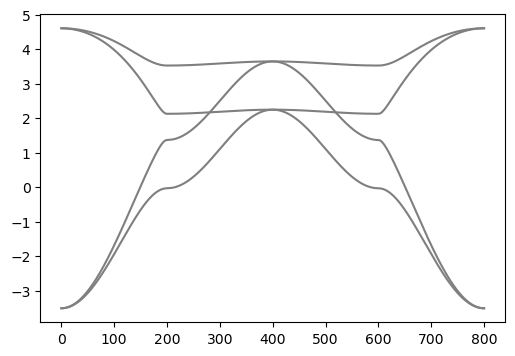

In [7]:
from utils.make_kpoints import abacus_kpath
import numpy as np
import matplotlib.pyplot as plt

kpoints, xpath, _ = abacus_kpath(
    atoms, 
    np.array([
        [0,0,0,200],
        [0.25,0.25,0,200],
        [0.0,0.5,0,200],
        [-0.25,0.25,0,200],
        [0,0,0,1]
    ])
    )

kpoints[:,:2] = np.stack([kpoints[:,:2].sum(-1), kpoints[:,0] - kpoints[:,1]], axis=-1)

data[_keys.KPOINT_KEY] = kpoints
data = HF.update_Fock(data)

F = data[_keys.HAMILTONIAN_KEY]
eigvals = np.linalg.eigvalsh(F)

fig = plt.figure(figsize=(6,4))
plt.plot(eigvals, c="tab:gray")
plt.show()

In [ ]:
from utils.wannier import get_wannier_blocks
from ase.io import read
import numpy as np
from data import AtomicData, AtomicDataDict, OrbitalMapper, _keys
from data.interfaces import block_to_feature
from hf.hf import HartreeFock
from hr2hk import HR2HK
from utils.make_kpoints import abacus_kpath, kmesh_sampling
import os

U = 17.397
J = 1.109 # 0.25 * U
Up = U - 2*J
Jp = J

blocks = get_wannier_blocks(
    atomic_symbol=["Eu", "O"],
    file="./EuO_hr.dat",
    target_basis_order={"Eu": ["d", "f"], "O": ["p"]},
    wannier_proj_orbital={"Eu": ["f", "d"], "O": ["p"]},
    orb_wan={"p": ["px", "py", "pz"], "d": ["dxy", "dyz", "dxz", "dx2-y2", "dz2"], "f":['fz3', 'fxz2', 'fyz2', 'fxyz', 'fx3-3xy2','f3x2y-y3','fx2z-y2z']},
    spinors=True
)


data = AtomicData.from_ase(
    atoms=read("./EuO.vasp"),
    r_max={"Eu": 12., "O": 12.},
    pbc=True
)

atoms = data.to_ase()

idp = OrbitalMapper(basis={"Eu": "1d1f", "O":"1p"}, spin_deg=False)
block_to_feature(data=data, idp=idp, blocks=blocks)
data = AtomicData.to_AtomicDataDict(data)
data[_keys.KPOINT_KEY] = kmesh_sampling([10,10,10], True)
data = idp(data)

HF = HartreeFock(
    basis=idp.basis,
    nocc=11,
    idx_intorb={"Eu":[1]},
    intparams={"Eu":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=2,
    mixer_options={"method": "Linear", "a": 0.7},
    overlap=False,
    dtype=np.float64
)

data = HF.run(max_iter=300,data=data, tol=1e-7, ntol=1e-7)

['0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '0-dxy', '0-dyz', '0-dxz', '0-dx2-y2', '0-dz2', '1-px', '1-py', '1-pz']
['0-dxy', '0-dyz', '0-dz2', '0-dxz', '0-dx2-y2', '0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '1-py', '1-pz', '1-px']
Iter   0: E = 118.463364, ΔD = 4.003328e-01
Iter   1: E = 115.181644, ΔD = 1.607273e-01
Iter   2: E = 114.289648, ΔD = 9.071583e-02
Iter   3: E = 114.027327, ΔD = 3.957696e-02
Iter   4: E = 113.945980, ΔD = 1.612731e-02
Iter   5: E = 113.922356, ΔD = 6.011035e-03
Iter   6: E = 113.915090, ΔD = 2.693196e-03
Iter   7: E = 113.912885, ΔD = 8.817714e-04
Iter   8: E = 113.912210, ΔD = 2.889851e-04
Iter   9: E = 113.912001, ΔD = 9.495320e-05
Iter  10: E = 113.911936, ΔD = 3.122046e-05
Iter  11: E = 113.911915, ΔD = 1.018947e-05
Iter  12: E = 113.911911, ΔD = 3.427102e-06
Iter  13: E = 113.911907, ΔD = 1.069303e-06
Iter  14: E = 113.911907, ΔD = 3.401233e-07
Iter  15: E = 113.911907, ΔD = 1

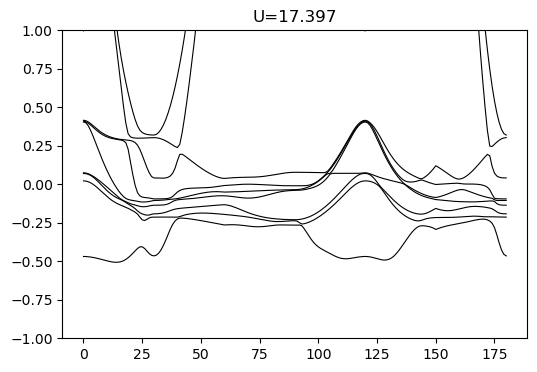

In [25]:
import matplotlib.pyplot as plt
kpoints, xx, _ = abacus_kpath(
    atoms,
    kpath=np.array([
        [0.0000000000,   0.0000000000,   0.0000000000,     30],
        [0.5000000000,   0.0000000000,   0.5000000000,     30],
        [0.5000000000,   0.2500000000,   0.7500000000,     30],
        [0.5000000000,   0.5000000000,   0.5000000000,     30],
        [0.0000000000,   0.0000000000,   0.0000000000,     30],
        [0.3750000000,   0.3750000000,   0.7500000000,     30],
        [0.5000000000,   0.0000000000,   0.5000000000,     1],
    ]
    )
)

data[_keys.KPOINT_KEY] = kpoints
data = HF.update_Fock(data)

F = data[_keys.HAMILTONIAN_KEY]
eigvals = np.linalg.eigvalsh(F)

fig = plt.figure(figsize=(6,4))
plt.plot(eigvals-data["efermi"], c="black", lw=0.8)
plt.title("U={}".format(U))
plt.ylim(-1,1)
plt.show()

In [22]:
np.diag(data[_keys.REDUCED_DENSITY_MATRIX_KEY]).real[:10].sum() + np.diag(data[_keys.REDUCED_DENSITY_MATRIX_KEY]).real[10:24].sum()

np.float64(5.610585071686643)

In [17]:
np.diag(data[_keys.REDUCED_DENSITY_MATRIX_KEY]).real[24:].sum()

np.float64(5.3477548905360255)